In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 1. Téléchargement du bon fichier (training2017.zip)
!wget -N https://physionet.org/files/challenge-2017/1.0.0/training2017.zip

# 2. Décompression
# Note : Cela va créer un dossier nommé 'training'
!unzip -q -o training2017.zip

--2025-12-17 10:29:55--  https://physionet.org/files/challenge-2017/1.0.0/training2017.zip
Resolving physionet.org (physionet.org)... 18.18.42.54
Connecting to physionet.org (physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99226822 (95M) [application/zip]
Saving to: ‘training2017.zip’

training2017.zip    100%[===================>]  94.63M   315KB/s    in 5m 17s  

2025-12-17 10:35:12 (306 KB/s) - ‘training2017.zip’ saved [99226822/99226822]



In [ ]:
import wfdb
import os

# Chemin vers le dossier décompressé
data_path = 'data/training2017/'

# Choisissons un fichier au hasard, par exemple A00001
record_name = 'A00001'

# Lecture de l'enregistrement (sans extension)
# rdrecord lit automatiquement le .mat et le .hea
record = wfdb.rdrecord(os.path.join(data_path, record_name))

# Extraction des informations clés
signal = record.p_signal  # Le signal ECG lui-même
fs = record.fs            # La fréquence d'échantillonnage (Hz)
comments = record.comments # Souvent vide pour ce dataset spécifique

print(f"Enregistrement : {record.record_name}")
print(f"Fréquence d'échantillonnage : {fs} Hz")
print(f"Forme du signal : {signal.shape}") # (Longeur, Nombre de leads)

Enregistrement : A00001
Fréquence d'échantillonnage : 300 Hz
Forme du signal : (9000, 1)


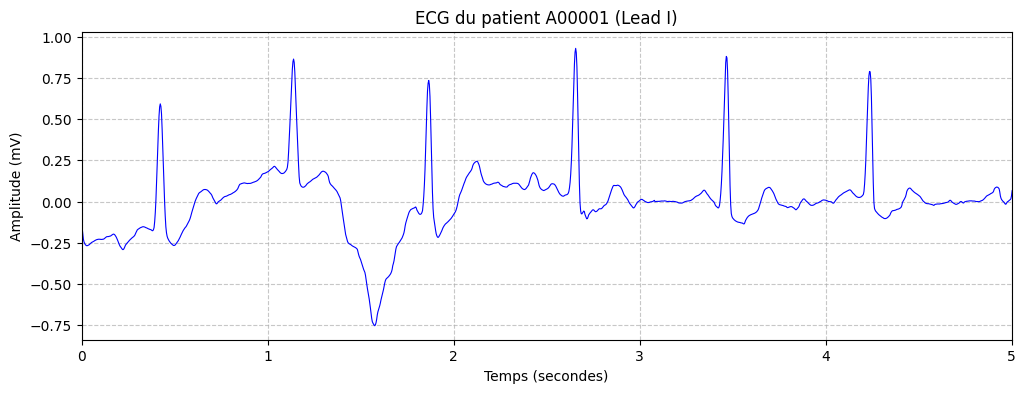

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Création de l'axe temporel (en secondes)
time = np.arange(len(signal)) / fs

plt.figure(figsize=(12, 4))
plt.plot(time, signal, color='blue', linewidth=0.8)

plt.title(f"Example of ECG recording from Physionet 2017 database")
plt.xlabel("Time (secondes)")
plt.ylabel("Amplitude (mV)")
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Zoomons sur les 5 premières secondes pour mieux voir les ondes P, QRS, T
plt.xlim(0, 5) 

plt.show()

In [8]:
import pandas as pd

# Chargement des références
labels_df = pd.read_csv("https://physionet.org/files/challenge-2017/1.0.0/training/REFERENCE.csv", header=None, names=['filename', 'label'])

# Afficher les 5 premières lignes
print(labels_df.head())

# Exemple : Trouver le label de notre fichier A00001
label_A00001 = labels_df[labels_df['filename'] == 'A00/A00001']['label'].values[0]
print(f"\nLe label pour A00001 est : {label_A00001}")

     filename label
0  A00/A00001     N
1  A00/A00002     N
2  A00/A00003     N
3  A00/A00004     A
4  A00/A00005     A

Le label pour A00001 est : N


In [1]:
def Lout(Lin, K, P, S) : 
    return np.abs((Lin+2*P-K)/S + 1)

In [4]:
Lout(1000,16,1,1)

np.float64(987.0)

In [22]:
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import pickle
def load_physionet() : 
    # read label
    label_df = pd.read_csv("https://physionet.org/files/challenge-2017/1.0.0/training/REFERENCE.csv", header=None, names=['filename', 'label'])
    label = label_df.iloc[:, 1].values
    print(Counter(label))

    # read data
    data_dir = Path('../training2017/')
    record_names = sorted([f.stem for f in data_dir.glob('*.hea')])
    print(f"J'ai trouvé {len(record_names)} fichiers dans {data_dir.resolve()}")
    all_data = []
    # filenames = pd.read_csv('../training2017', header=None)
    # filenames = filenames.iloc[:, 0].values
    

    

    for record_name in tqdm(record_names):
        # rdrecord lit automatiquement le .mat et le .hea
        record = wfdb.rdrecord(str(data_dir / record_name))
        # Extraction des informations clés
        signal = record.p_signal  # Le signal ECG lui-même
        if signal.shape[1] == 1:
                signal = signal.flatten()
                
        all_data.append(signal)

    all_data = np.array(all_data, dtype=object)

    res = {'data': all_data, 'label': label}
    with open('../challenge2017.pkl', 'wb') as fout:
        pickle.dump(res, fout)

In [23]:
load_physionet()

Counter({'N': 5076, 'O': 2415, 'A': 758, '~': 279})
J'ai trouvé 0 fichiers dans /home/onyxia/training2017


0it [00:00, ?it/s]


In [ ]:
from resnet1d import MyDataset

# read pkl
with open('../challenge2017.pkl', 'rb') as fin:
    data = pickle.load(fin)

dataset = MyDataset(data['data'], data['label'])

In [ ]:
import numpy as np
import os
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

from load_data import ECGDataset, ECGCollate, SmartBatchSampler, load_dataset, load_ecg
from resnet1d import ResNet1D

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

2026-01-05 12:04:15.431272: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-05 12:04:15.496265: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-05 12:04:17.265861: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/opt/python/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
print("Loading training set...")
train = load_dataset("train.json",256)
ecgs, labels = train
print(f"len(X) : \n {len(ecgs)}")
print(f"len(y) : \n {len(labels)}")
for i in range(3):
    print(f"ecg_{i} : \n {ecgs[i]}")
    print(f"len(ecg_{i}) : {len(ecgs[i])}")
    print(f"label_{i} :\n {labels[i]}")
    print(f"len(label_{i}) : {len(labels[i])}")

Loading training set...


100%|██████████| 7676/7676 [00:01<00:00, 4808.55it/s]

len(X) : 
 7676
len(y) : 
 7676
ecg_0 : 
 [  72   83   93 ... -136 -133 -131]
len(ecg_0) : 8960
label_0 :
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
len(label_0) : 35
ecg_1 : 
 [-137 -167 -200 ...  -50  -51  -51]
len(ecg_1) : 8960
label_1 :
 ['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']
len(label_1) : 35
ecg_2 : 
 [620 780 914 ... 102 115 116]
len(ecg_2) : 8960
label_2 :
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
len(label_2) : 35


In [4]:
print("Loading dev set...")
val = load_dataset("dev.json",256)

Loading dev set...


100%|██████████| 852/852 [00:00<00:00, 4962.65it/s]


In [5]:
train_dataset = ECGDataset(*train)
val_dataset = ECGDataset(*val)

MEAN :  7.4661856  STD :  236.10312
self.classes :  ['A', 'N', 'O', '~']
self.class_to_int :  {'A': 0, 'N': 1, 'O': 2, '~': 3}
MEAN :  8.029898  STD :  242.35907
self.classes :  ['A', 'N', 'O', '~']
self.class_to_int :  {'A': 0, 'N': 1, 'O': 2, '~': 3}


In [6]:

# Instanciation du Sampler intelligent
train_batch_sampler = SmartBatchSampler(train_dataset, 32)
val_batch_sampler = SmartBatchSampler(val_dataset, 32)

train_collate_fn = ECGCollate(
    pad_val_x=train_dataset.pad_value_x_normalized,
    num_classes=train_dataset.num_classes
)

val_collate_fn = ECGCollate(
    pad_val_x=val_dataset.pad_value_x_normalized,
    num_classes=val_dataset.num_classes
)

train_loader = DataLoader(
    train_dataset,
    batch_sampler=train_batch_sampler, 
    collate_fn=train_collate_fn,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_sampler=val_batch_sampler, 
    collate_fn=val_collate_fn,
    num_workers=4
)

Tri du dataset par longueur pour minimiser le padding...
Tri du dataset par longueur pour minimiser le padding...


In [6]:
%load_ext tensorboard
%tensorboard --logdir logs --port 6006

In [ ]:
def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable),total=len(iterable), ncols=150, desc=desc)


def train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=10, name="default"):
    """
    Train the classifier for a number of epochs.
    """
    loss_cutoff = len(train_loader) // 10
    optimizer = torch.optim.Adam(model.parameters(), 0.001)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                            mode='min', 
                                                            factor=0.1, # like in Hannun et al.
                                                            patience=2 # 2 in Hannun et al. "two consecutive epochs"
                                                            )
    for epoch in range(epochs):

        # Training stage, where we want to update the parameters.
        model.train()  # Set the model to training mode

        training_loss = []
        validation_loss = []

        # Create a progress bar for the training loop.
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]')
        for train_iteration, batch in training_loop:
            optimizer.zero_grad() # Reset the gradients - VERY important! Otherwise they accumulate.
            ecgs, labels = batch # Get the images and labels from the batch, in the fashion we defined in the dataset and dataloader.
            ecgs, labels = ecgs.to(device), labels.to(device) # Send the data to the device (GPU or CPU) - it has to be the same device as the model.

            # Flatten the images to a vector. This is done because the classifier expects a vector as input.
            # Could also be done by reshaping the images in the dataset.
            # images = images.view(images.shape[0], -1)

            pred = model(ecgs) # Stage 1: Forward().
            loss = loss_func(pred, labels) # Compute the loss over the predictions and the ground truth.
            loss.backward()  # Stage 2: Backward().
            optimizer.step() # Stage 3: Update the parameters.
            # scheduler.step() # Update the learning rate.


            training_loss.append(loss.item())
            training_loss = training_loss[-loss_cutoff:]

            # Update the progress bar.
            training_loop.set_postfix(curr_train_loss = "{:.8f}".format(np.mean(training_loss)),
                                      lr = "{:.8f}".format(optimizer.param_groups[0]['lr'])
            )

            # Update the tensorboard logger.
            tb_logger.add_scalar(f'classifier_{name}/train_loss', loss.item(), epoch * len(train_loader) + train_iteration)

        # Validation stage, where we don't want to update the parameters. Pay attention to the classifier.eval() line
        # and "with torch.no_grad()" wrapper.
        model.eval()
        val_loop = create_tqdm_bar(val_loader, desc=f'Validation Epoch [{epoch + 1}/{epochs}]')

        with torch.no_grad():
            for val_iteration, batch in val_loop:
                ecgs, labels = batch
                ecgs, labels = ecgs.to(device), labels.to(device)

                pred = model(ecgs)
                loss = loss_func(pred, labels)
                validation_loss.append(loss.item())
                # Update the progress bar.
                val_loop.set_postfix(val_loss = "{:.8f}".format(np.mean(validation_loss)))

                # Update the tensorboard logger.
                tb_logger.add_scalar(f'classifier_{name}/val_loss', loss.item(), epoch * len(val_loader) + val_iteration)
        
        scheduler.step(np.mean(validation_loss))


In [17]:
# Create a tensorboard logger.
# NOTE: In order to see the logs, run the following command in the terminal: tensorboard --logdir=./
# Also, in order to reset the logs, delete the logs folder MANUALLY.

path = "logs"
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')

tb_logger = SummaryWriter(path)

epochs = 20

loss_func = nn.CrossEntropyLoss() # The loss function we use for classification.

# make model
device_str = "cuda"
device = torch.device(device_str if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")

kernel_size = 16 # 16 in Hannun et al.
stride = 2
n_block = 16 # 16 in Hannun et al.
downsample_gap = 2 # 2 in Hannun et al.
increasefilter_gap = 4 # 4 in Hannun et al.

model = ResNet1D(
    in_channels=1, 
    base_filters=32, # 32 in Hannun et al.
    kernel_size=kernel_size, 
    stride=stride, 
    groups=1, # like a classical ResNet
    n_block=n_block, 
    n_classes=4, 
    downsample_gap=downsample_gap, 
    increasefilter_gap=increasefilter_gap, 
    use_bn=True,
    use_do=True
    )

model.to(device)

summary(model, (1,100), device=device_str)

model.verbose = False

train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=epochs, name="Default")

print()
print("Finished training!")

Running on cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 100]             544
   MyConv1dPadSame-2              [-1, 32, 100]               0
       BatchNorm1d-3              [-1, 32, 100]              64
              ReLU-4              [-1, 32, 100]               0
            Conv1d-5              [-1, 32, 100]          16,416
   MyConv1dPadSame-6              [-1, 32, 100]               0
       BatchNorm1d-7              [-1, 32, 100]              64
              ReLU-8              [-1, 32, 100]               0
           Dropout-9              [-1, 32, 100]               0
           Conv1d-10              [-1, 32, 100]          16,416
  MyConv1dPadSame-11              [-1, 32, 100]               0
       BasicBlock-12              [-1, 32, 100]               0
      BatchNorm1d-13              [-1, 32, 100]              64
             ReLU-14   

Validation Epoch [20/20]: 100%|██████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 15.71it/s, val_loss=0.39092661]


Finished training!


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import scipy.stats as sst
from sklearn.metrics import classification_report, precision_recall_fscore_support

def evaluate_model_full(model, dataloader, device):
    """
    Évalue le modèle en faisant un vote majoritaire sur les séquences temporelles.
    Gère le padding (-100) pour ne pas fausser le vote.
    """
    model.eval()
    
    final_preds = []
    final_gts = [] # Ground Truths

    # Récupération des noms de classes (ex: ['A', 'N', 'O', '~'])
    class_names = dataloader.dataset.classes
    print(f"Evaluation sur les classes : {class_names}")

    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            # y_batch reste sur CPU pour traitement numpy
            # y_batch contient des 0, 1, 2, 3 (classes) et des -100 (padding)
            
            # 1. Forward Pass
            # Le modèle sort [Batch, Classes, Seq_Len]
            logits = model(x_batch)
            
            # 2. Conversion en probabilités
            probs = F.softmax(logits, dim=1).cpu().numpy()
            y_batch_np = y_batch.numpy()
            
            # 3. Traitement exemple par exemple (Vote Majoritaire)
            for i in range(len(y_batch_np)):
                # Récupération des données brutes pour l'exemple i
                # p_i : [Classes, Seq_Len]
                # y_i : [Seq_Len]
                p_i = probs[i] 
                y_i = y_batch_np[i]
                
                # --- FILTRAGE DU PADDING ---
                # On ne garde que les indices qui ne sont PAS du padding (-100)
                # Cela conserve la classe 3 ('~') car 3 != -100
                valid_mask = (y_i != -100)
                
                if valid_mask.sum() > 0:
                    # On extrait la séquence valide (sans les zéros ajoutés à la fin)
                    valid_p = p_i[:, valid_mask] # Forme : [Classes, Vraie_Longueur]
                    valid_y = y_i[valid_mask]    # Forme : [Vraie_Longueur]
                    
                    # --- Logique de vote majoritaire (Ton algorithme original) ---
                    
                    predictions_seq = np.argmax(valid_p, axis=0)

                    # Vote Majoritaire (Mode) sur la séquence temporelle
                    # On prend la classe la plus fréquente dans la séquence prédite
                    pred_label = sst.mode(predictions_seq, keepdims=True)[0][0]
                    
                    # Pour la vérité terrain, on prend aussi le mode (normalement constant)
                    gt_label = sst.mode(valid_y, keepdims=True)[0][0]
                    
                    final_preds.append(pred_label)
                    final_gts.append(gt_label)

    # --- Affichage des Résultats ---
    print("\n" + "="*60)
    print("RAPPORT DE CLASSIFICATION (Vote Majoritaire par ECG)")
    print("="*60)
    
    # Rapport complet incluant '~'
    print(classification_report(
        final_gts, 
        final_preds, 
        target_names=class_names, 
        digits=3,
        zero_division=0
    ))

    # Calcul des scores bruts pour le "CINC Average"
    scores = precision_recall_fscore_support(
        final_gts, 
        final_preds, 
        average=None,
        zero_division=0
    )
    
    # CINC Average : Moyenne des F1-scores des 3 premières classes (A, N, O)
    # On suppose que '~' est la dernière classe (index 3) et on l'exclut de cette moyenne spécifique
    f1_scores = scores[2]
    cinc_average = np.mean(f1_scores[:3])
    
    print("-" * 30)
    print("F1-Scores par classe :")
    for name, score in zip(class_names, f1_scores):
        print(f"  {name} : {score:.4f}")
    
    print("-" * 30)
    print("CINC Average (Mean F1 of A, N, O) : {:3f}".format(cinc_average))
    print("="*60)

# --- Exemple d'utilisation ---
evaluate_model_full(model, val_loader, device=device, prior=None)

Evaluation sur les classes : ['A', 'N', 'O', '~']

RAPPORT DE CLASSIFICATION (Vote Majoritaire par ECG)
              precision    recall  f1-score   support

           A      0.851     0.875     0.863        72
           N      0.909     0.922     0.915       486
           O      0.821     0.834     0.828       259
           ~      0.818     0.514     0.632        35

    accuracy                          0.874       852
   macro avg      0.850     0.786     0.809       852
weighted avg      0.874     0.874     0.873       852

------------------------------
F1-Scores par classe :
  A : 0.8630
  N : 0.9152
  O : 0.8276
  ~ : 0.6316
------------------------------
CINC Average (Mean F1 of A, N, O) : 0.868607
